# **How many subscribers will be on-line in my network next week?**

For several reasons, we need to predict what the network will look like at a certain point in the future. We want to forecast traffic accurately to plan capacity provisioning in advance, forecast subscribers to plan for IP address pool capacity, and forecast user demand to plan for our K8s cluster capacity. Failure to do so could result in service unavailability, missed SLAs, and potential customer churn.

So, how can we make reasonable predictions for a specific metric to take action now based on future forecasts? This is the main issue we aim to solve. In this case, we want to properly plan the capacity of IP address pools for our BNGs by estimating the number of subscribers expected over the coming days at different hours. If successful, this will provide a solid basis for determining the necessary size of the IP pools and provisioning them accordingly.

# Connection to drive and path definition (Just for Google Colab Lab)




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import sys
path_files ='/content/drive/MyDrive/Colab Notebooks/Files'

# ***OR***
# Connection path definition (Just for AWS Jupiter Notebook)

In [1]:
import sys
path_files ='./Files'

# Import libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error
from datetime import datetime
from sklearn.preprocessing import  StandardScaler
from os.path import join
import statsmodels.api as sm

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint




2025-09-25 16:25:25.654439: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758817525.674437    3177 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758817525.680605    3177 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1758817525.696242    3177 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1758817525.696258    3177 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1758817525.696261    3177 computation_placer.cc:177] computation placer alr

In [4]:
print("TensorFlow version:", tf.__version__)
print("GPUs available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.19.0
GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Data Collection

## We will load a data set that contains number of subscribers for PE-5 for a period of 29 days, with 2 minute frequency

In [5]:
metric_df=pd.read_csv(join(path_files,'bng_subscribers_metric_forecast.csv'),index_col=0)

In [6]:
metric_df

,timestamp,bng_subscribers,device_name,vendor,model,os,version,hw_revision,role,ip_address
0,1759276801,1455.475425,PE-5,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.5
1,1759276921,1446.721881,PE-5,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.5
2,1759277041,1512.511090,PE-5,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.5
3,1759277161,1468.672225,PE-5,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.5
4,1759277281,1430.314245,PE-5,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.5
...,...,...,...,...,...,...,...,...,...,...
20875,1761781801,3328.592459,PE-5,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.5
20876,1761781921,3344.212696,PE-5,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.5
20877,1761782041,3338.026703,PE-5,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.5
20878,1761782161,3291.407172,PE-5,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.5


# Data preparation

In [7]:
ds_column = []
for i,obs in metric_df.iterrows():
    new_timestamp = datetime.fromtimestamp(obs['timestamp'])
    ds_column.append(new_timestamp)
metric_df['ds']=ds_column
metric_df['y']=metric_df['bng_subscribers']



In [8]:
metric_df

,timestamp,bng_subscribers,device_name,vendor,model,os,version,hw_revision,role,ip_address,ds,y
0,1759276801,1455.475425,PE-5,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.5,2025-10-01 00:00:01,1455.475425
1,1759276921,1446.721881,PE-5,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.5,2025-10-01 00:02:01,1446.721881
2,1759277041,1512.511090,PE-5,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.5,2025-10-01 00:04:01,1512.511090
3,1759277161,1468.672225,PE-5,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.5,2025-10-01 00:06:01,1468.672225
4,1759277281,1430.314245,PE-5,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.5,2025-10-01 00:08:01,1430.314245
...,...,...,...,...,...,...,...,...,...,...,...,...
20875,1761781801,3328.592459,PE-5,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.5,2025-10-29 23:50:01,3328.592459
20876,1761781921,3344.212696,PE-5,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.5,2025-10-29 23:52:01,3344.212696
20877,1761782041,3338.026703,PE-5,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.5,2025-10-29 23:54:01,3338.026703
20878,1761782161,3291.407172,PE-5,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.5,2025-10-29 23:56:01,3291.407172


Text(0.5, 1.0, 'BNG Subscribers')

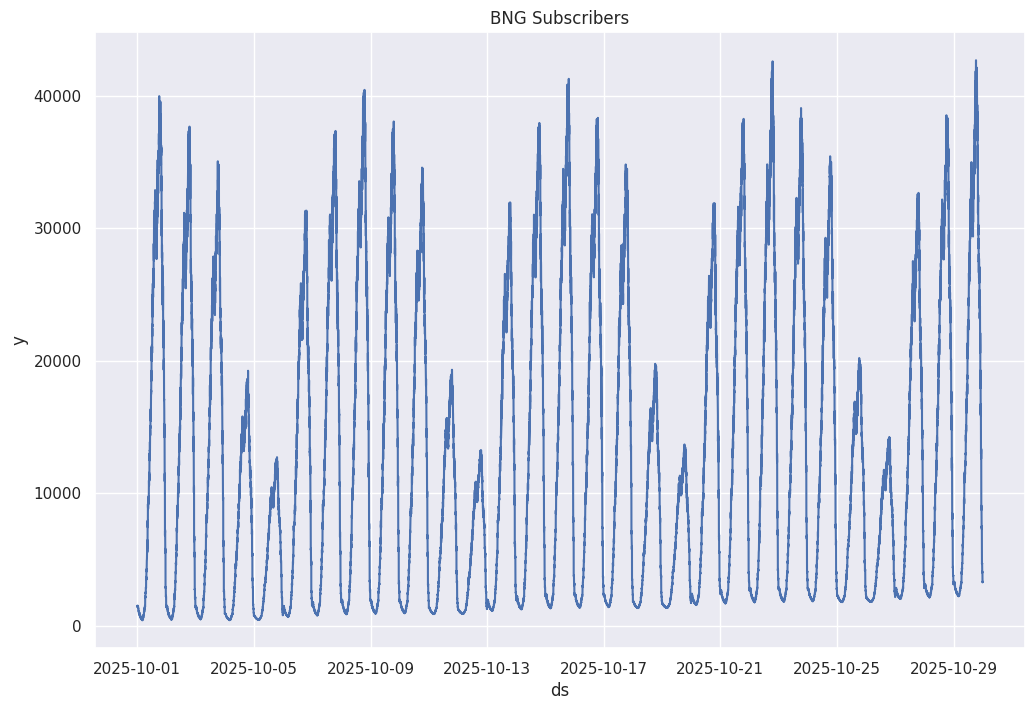

In [9]:
# Visualize data using seaborn
sns.set(rc={'figure.figsize':(12,8)})
sns.lineplot(x=metric_df['ds'], y=metric_df['y'])
plt.title('BNG Subscribers')

In [10]:
df = metric_df[['ds','y']].set_index('ds')


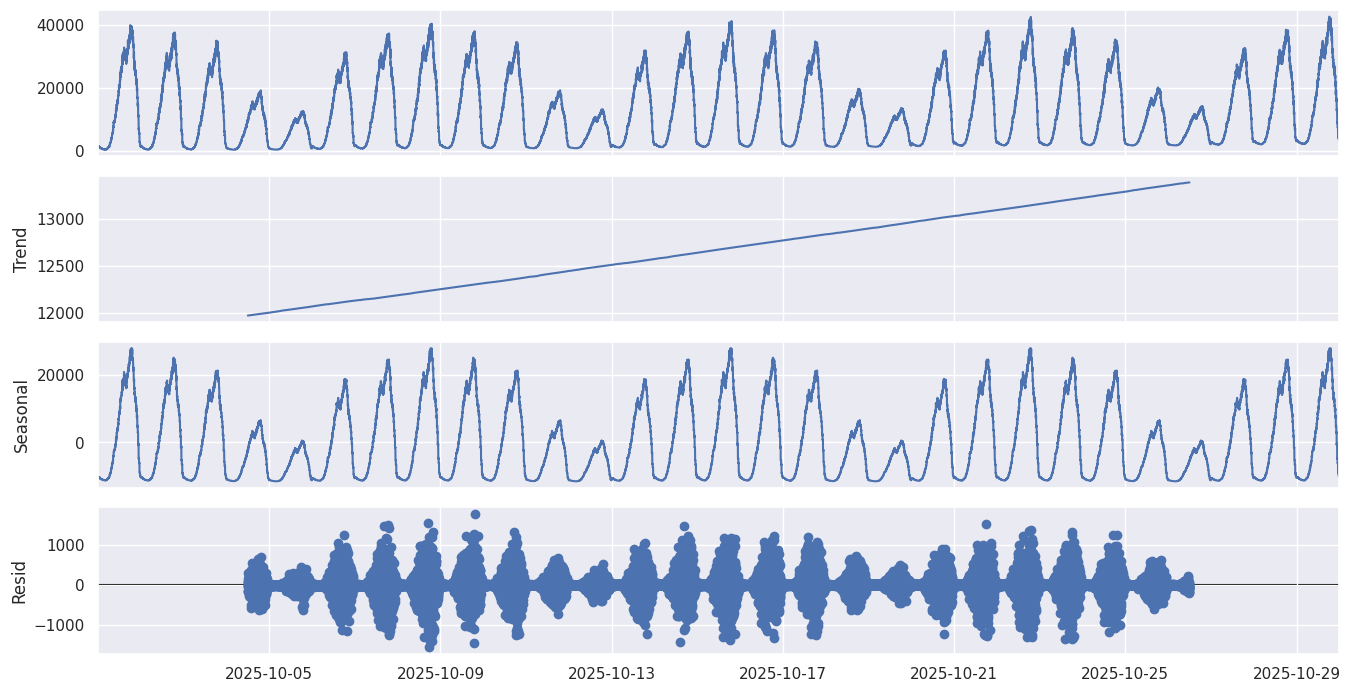

(ds
 2025-10-01 00:00:01   NaN
 2025-10-01 00:02:01   NaN
 2025-10-01 00:04:01   NaN
 2025-10-01 00:06:01   NaN
 2025-10-01 00:08:01   NaN
                        ..
 2025-10-29 23:50:01   NaN
 2025-10-29 23:52:01   NaN
 2025-10-29 23:54:01   NaN
 2025-10-29 23:56:01   NaN
 2025-10-29 23:58:01   NaN
 Name: trend, Length: 20880, dtype: float64,
 ds
 2025-10-01 00:00:01   -10287.040227
 2025-10-01 00:02:01   -10262.650665
 2025-10-01 00:04:01   -10278.455709
 2025-10-01 00:06:01   -10300.865540
 2025-10-01 00:08:01   -10275.890595
                            ...     
 2025-10-29 23:50:01   -10290.673880
 2025-10-29 23:52:01   -10267.248666
 2025-10-29 23:54:01   -10298.438959
 2025-10-29 23:56:01   -10278.304241
 2025-10-29 23:58:01   -10280.781686
 Name: seasonal, Length: 20880, dtype: float64,
 ds
 2025-10-01 00:00:01   NaN
 2025-10-01 00:02:01   NaN
 2025-10-01 00:04:01   NaN
 2025-10-01 00:06:01   NaN
 2025-10-01 00:08:01   NaN
                        ..
 2025-10-29 23:50:01   NaN
 2

In [11]:
def seasonal_decompose (df):
    decomposition = sm.tsa.seasonal_decompose(df, model='additive',period=5040)

    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    fig = decomposition.plot()
    fig.set_size_inches(14, 7)
    plt.show()

    return trend, seasonal, residual

seasonal_decompose(df)

In statsmodels, when you use *decomposition.resid*, it gives you the residual component of the time series after removing the trend and seasonality. The residual represents the part of the data that cannot be explained by the trend and seasonality, and it typically includes noise or random fluctuations.

**LSTM**

In [12]:
time_steps = 5040
next_predict = 720

In [13]:
train_pct = 0.95


In [14]:
scaler = StandardScaler()
scaler = scaler.fit(metric_df[['y']])
metric_df['y_scaled']=scaler.transform(metric_df[['y']])


In [15]:
metric_df.y_scaled.shape

(20880,)

FORMATING FOR LSTM

In [16]:
Xs, ys, ys_next = [], [], []
for i in range(metric_df.shape[0] - (time_steps+next_predict)):
    v = metric_df[['y_scaled']].iloc[i:(i + time_steps)].values
    Xs.append(v)
    w = metric_df[['y_scaled']].iloc[(i+time_steps):(i + time_steps+next_predict)].values
    ys.append(w)

x = np.array(Xs)
y = np.array(ys)


x (features de entrada al modelo)
Es un tensor con las ventanas deslizantes de time_steps puntos pasados. Dimensiones típicas: (n_samples, time_steps, 1)

y (objetivo / etiqueta a predecir)
Es un tensor con la(s) siguiente(s) observación(es) después de cada ventana de entrada. Dimensiones típicas: (n_samples, next_predict, 1)


In [17]:
x.shape

(15120, 5040, 1)

In [18]:
y.shape

(15120, 720, 1)

DATA SPLITTING

In [19]:
train_size = int(x.shape[0]*train_pct)
test_size = x.shape[0]-train_size

In [20]:
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

## MODEL DEFINITION

In [21]:

model = keras.Sequential()
model.add(keras.layers.Input(shape=(x_train.shape[1], x_train.shape[2])))
model.add(keras.layers.LSTM(192, return_sequences=True, activation='tanh'))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.LSTM(128, return_sequences=False))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(512, activation='tanh'))  
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(256, activation='tanh'))   
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(720))
model.add(keras.layers.Reshape((720, 1)))

opt = keras.optimizers.Adam(learning_rate=5e-4)  
model.compile(loss='mse', optimizer=opt, metrics=['mse'])


I0000 00:00:1758817639.043250    3177 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20793 MB memory:  -> device: 0, name: NVIDIA A10G, pci bus id: 0000:00:1e.0, compute capability: 8.6


In [22]:
print("X:", x_train.shape, "Y:", y_train.shape, "Out:", model.output_shape)


X: (14364, 5040, 1) Y: (14364, 720, 1) Out: (None, 720, 1)


In [23]:

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 5040, 192)      │       148,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 5040, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 720)            │       185,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 720, 1)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 695,760 (2.65 MB)

 Trainable params: 695,760 (2.65 MB)

 Non-trainable params: 0 (0.00 B)

## MODEL TRAINING

In [24]:


callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-5, verbose=1),
    keras.callbacks.ModelCheckpoint("best_lstm.keras", monitor="val_loss", save_best_only=True)
]

# --- Entrenamiento ---
history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),   # validación sobre el split temporal final
    epochs=50,
    batch_size=32,                      # si hay OOM, prueba 8; si sobra RAM/GPU, prueba 32
    callbacks=callbacks,
    verbose=1
)


Epoch 1/50


I0000 00:00:1758817664.502622    3319 cuda_dnn.cc:529] Loaded cuDNN version 90300


449/449 ━━━━━━━━━━━━━━━━━━━━ 118s 255ms/step - loss: 0.4564 - mse: 0.4564 - val_loss: 0.4520 - val_mse: 0.4520 - learning_rate: 5.0000e-04
Epoch 2/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 114s 254ms/step - loss: 0.2303 - mse: 0.2303 - val_loss: 0.1526 - val_mse: 0.1526 - learning_rate: 5.0000e-04
Epoch 3/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 114s 254ms/step - loss: 0.2039 - mse: 0.2039 - val_loss: 0.1293 - val_mse: 0.1293 - learning_rate: 5.0000e-04
Epoch 4/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 114s 254ms/step - loss: 0.1884 - mse: 0.1884 - val_loss: 0.1386 - val_mse: 0.1386 - learning_rate: 5.0000e-04
Epoch 5/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 114s 254ms/step - loss: 0.1474 - mse: 0.1474 - val_loss: 0.1175 - val_mse: 0.1175 - learning_rate: 5.0000e-04
Epoch 6/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 114s 254ms/step - loss: 0.1061 - mse: 0.1061 - val_loss: 0.0726 - val_mse: 0.0726 - learning_rate: 5.0000e-04
Epoch 7/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 114s 254ms/step - loss: 0.0853 - mse: 0.0853 - val_loss: 0.0599 - val_m

In [ ]:
# --- (Opcional) Gráfica de curvas de entrenamiento ---
import matplotlib.pyplot as plt
plt.figure()
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Curvas de entrenamiento")
plt.legend()
plt.show()

## MODEL EVALUATION

In [ ]:

# --- Evaluación ---
test_loss, test_mse = model.evaluate(x_test, y_test, verbose=0)
print(f"Test MSE: {test_mse:.6f}")

# --- Predicción de ejemplo y shapes ---
y_pred = model.predict(x_test[:1], verbose=0)   # (1, 720, 1)
print("y_pred shape:", y_pred.shape)



In [ ]:
model.save_weights(join(path_files,"weights_lstm_forecast.weights.h5"))

In [ ]:
model.save(join(path_files, "model_forecasting.keras"))

In [ ]:
score, acc = model.evaluate(x_test, y_test)

In [ ]:
PLOT PREDICTION

In [ ]:

y_pred_all = model.predict(x_test, verbose=0)

# =========================
# 2) Función de evaluación por muestra (idx relativo a test)
# =========================
def evaluate_sample(idx, x_test, y_test, y_pred_all, scaler):

    assert 0 <= idx < y_pred_all.shape[0], f"idx fuera de rango 0..{y_pred_all.shape[0]-1}"

    # y_true/y_pred escaladas -> invertimos a escala original
    y_true_inv = scaler.inverse_transform(y_test[idx].reshape(-1, 1)).ravel()   # (horizon,)
    y_pred_inv = scaler.inverse_transform(y_pred_all[idx].reshape(-1, 1)).ravel()

    mae = mean_absolute_error(y_true_inv, y_pred_inv)
    mape = mean_absolute_percentage_error(y_true_inv, y_pred_inv)
    return mae, mape, y_true_inv, y_pred_inv

# =========================
# 3) Función para graficar alineado en el tiempo
# =========================
def plot_prediction_aligned(metric_df, idx_test, train_size, time_steps, next_predict, y_pred_all, scaler, scope=4016, label="bng_subscribers"):
    """
    Grafica el contexto histórico + futuro predicho para la muestra idx_test """
    n_test = y_pred_all.shape[0]
    assert 0 <= idx_test < n_test, f"idx_test fuera de rango 0..{n_test-1}"

    # Índice 'i' global de la ventana (como en el bucle original que generó X/Y)
    i_global = train_size + idx_test

    # Rango temporal del horizonte verdadero en el DataFrame original
    start_pred = i_global + time_steps
    end_pred = start_pred + next_predict  # exclusivo

    # Chequeos de borde
    N = len(metric_df)
    start_pred = max(0, min(start_pred, N))
    end_pred = max(0, min(end_pred, N))

    # Contexto histórico (antes del horizonte)
    start_ctx = max(0, start_pred - scope)

    # Serie real (contexto + futuro real)
    real_time = metric_df.iloc[start_ctx:end_pred].ds
    real_values = metric_df.iloc[start_ctx:end_pred]['y'].values

    # Tiempos exactos del horizonte para la predicción
    pred_time = metric_df.iloc[start_pred:end_pred].ds

    # Predicción invertida (escala original)
    y_pred_inv = scaler.inverse_transform(y_pred_all[idx_test].reshape(-1, 1)).ravel()

    # Asegurar igual longitud por seguridad (recortes si hay bordes)
    cut = min(len(pred_time), len(y_pred_inv))
    pred_time = pred_time.iloc[:cut]
    y_pred_inv = y_pred_inv[:cut]

    # Graficar
    plt.figure(figsize=(12, 5))
    sns.lineplot(x=real_time, y=real_values, label=f"actual {label}")
    sns.lineplot(x=pred_time, y=y_pred_inv, label=f"predicted {label}")
    plt.title(f"Predicción (test idx={idx_test}) — scope={scope}, horizon={next_predict}")
    plt.xlabel("Tiempo")
    plt.ylabel(label)
    plt.legend()
    plt.tight_layout()
    plt.show()

# =========================
# 4) Ejemplo de uso: evaluar y graficar un sample
# =========================
idx = 0  # cambia a 0..(y_pred_all.shape[0]-1)
mae, mape, y_true_inv, y_pred_inv = evaluate_sample(idx, x_test, y_test, y_pred_all, scaler)
print(f"[Sample {idx}] MAE: {mae:.4f} | MAPE: {mape:.2%}")

plot_prediction_aligned(
    metric_df=metric_df,
    idx_test=idx,
    train_size=train_size,
    time_steps=x_train.shape[1],     # debería ser tu variable time_steps (5040)
    next_predict=y_train.shape[1],   # debería ser tu variable next_predict (720)
    y_pred_all=y_pred_all,
    scaler=scaler,
    scope=4016,
    label="bng_subscribers"
)

# =========================
# 5) Métricas globales sobre TODO el test
# =========================
# Invertimos todo para evaluar en escala original
y_test_inv_all = scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(y_test.shape[0], y_test.shape[1])
y_pred_inv_all = scaler.inverse_transform(y_pred_all.reshape(-1, 1)).reshape(y_pred_all.shape[0], y_pred_all.shape[1])

# MAE/MAPE promedio por muestra (promediando todo el horizonte)
mae_per_sample = [mean_absolute_error(y_test_inv_all[i], y_pred_inv_all[i]) for i in range(y_test_inv_all.shape[0])]
mape_per_sample = [mean_absolute_percentage_error(y_test_inv_all[i], y_pred_inv_all[i]) for i in range(y_test_inv_all.shape[0])]

print(f"[GLOBAL] MAE medio:  {np.mean(mae_per_sample):.4f}")
print(f"[GLOBAL] MAPE medio: {np.mean(mape_per_sample):.2%}")
